In [10]:
# Analisis otomatis + laporan berdasarkan data CSV
# Jalankan di Jupyter / VS Code Notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D scatter if dipakai
import textwrap
import os

# -----------------------
# Konfigurasi
CSV_PATH = r"C:/Data/studikasus1.csv"   # <-- ganti sesuai lokasi file kamu
OUT_DIR = "analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
np.set_printoptions(precision=3, suppress=True)

# -----------------------
# 1) Baca data
df = pd.read_csv(CSV_PATH)
print("Loaded CSV with columns:", df.columns.tolist())

# 2) Deteksi dan normalisasi nama kolom water quality
possible_wq = ['rataan_kualitas_air', 'kualitas_air', 'water_quality', 'avg_water_quality', 'mean_water_quality']
wq_found = None
for name in possible_wq:
    if name in df.columns:
        wq_found = name
        break

if wq_found:
    df = df.rename(columns={wq_found: 'water_quality'})
    print(f"Detected water-quality column '{wq_found}' -> renamed to 'water_quality'.")
else:
    print("Warning: Tidak menemukan kolom water quality (candidates:", possible_wq, "). Analisis water quality akan dilewati.")
    
# 3) Pastikan kolom yang diperlukan ada
expected_cols = {
    'regulatory': ['permit_status', 'land_type', 'boundary_defined'],
    'biodiv': ['species_count', 'tree_density', 'water_quality']
}

present = {k: [c for c in v if c in df.columns] for k, v in expected_cols.items()}
print("Present columns by group:", present)

# 4) Bersihkan nama kolom (hapus spasi di awal/akhir)
df.columns = df.columns.str.strip()

# 5) Encode kolom kategorikal regulatory jika perlu (hanya jika kolom ada)
encoders = {}
for col in present['regulatory']:
    if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # pastikan string supaya LabelEncoder konsisten
        df[col] = le.fit_transform(df[col])
        encoders[col] = {i: label for i, label in enumerate(le.classes_)}
        print(f"Encoded '{col}' with mapping sample (first 6):", dict(list(encoders[col].items())[:6]))

# 6) Konversi kolom biodiv ke numeric jika perlu
for col in present['biodiv']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 7) Hitung korelasi numerik
corr_matrix = df.corr(numeric_only=True)
# Filter korelasi regulator vs biodiv (hanya yang tersedia)
available_reg = present['regulatory']
available_bio = [c for c in present['biodiv'] if c in df.columns]
if len(available_reg) == 0 or len(available_bio) == 0:
    print("Tidak cukup kolom untuk menghitung korelasi regulator vs biodiv.")
else:
    filtered_corr = corr_matrix.loc[available_reg, available_bio]
    print("\nFiltered correlation (regulatory x biodiv):\n", filtered_corr.round(3))

    # 8) Simpan heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(filtered_corr, annot=True, fmt=".3f", cmap="coolwarm", vmin=-1, vmax=1, center=0)
    plt.title("Correlation: Regulatory Factors vs Biodiversity Metrics")
    plt.tight_layout()
    heatmap_path = os.path.join(OUT_DIR, "filtered_mangrove_correlation_heatmap.png")
    plt.savefig(heatmap_path, dpi=150)
    plt.close()
    print(f"Heatmap saved to: {heatmap_path}")

# 9) (Opsional) Buat 3D scatter jika kolom tertentu ada (deteksi otomatis)
# Example columns that may produce a 3D scatter (ganti sesuai dataset kalau perlu)
scatter_cols_candidates = [
    ('jumlah_dana', 'penyerapan_co2', 'tingkat_enkripsi'),
    ('fund_amount', 'co2_absorption', 'encryption_level')
]
scatter_made = False
for (a, b, c) in scatter_cols_candidates:
    if all(col in df.columns for col in (a,b,c)):
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(df[a], df[b], df[c], s=60)
        ax.set_xlabel(a.replace('_', ' ').title())
        ax.set_ylabel(b.replace('_', ' ').title())
        ax.set_zlabel(c.replace('_', ' ').title())
        ax.set_title("Scatter 3D: {} vs {} vs {}".format(a, b, c))
        scatter_path = os.path.join(OUT_DIR, "scatter_3d_optional.png")
        plt.savefig(scatter_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"3D scatter saved to: {scatter_path}")
        scatter_made = True
        break
if not scatter_made:
    print("No appropriate 3D-scatter column set found. Skipping 3D scatter.")

# 10) Buat ringkasan numerik per kategori regulatory (mean)
group_summary = {}
for col in available_reg:
    # Untuk interpretasi lebih baik: balikkan ke kategori string jika encoding ada mapping
    if col in encoders:
        # kita butuh mapping value->label; encoders[col] is idx->label so invert
        inv_map = {int(k): v for k, v in encoders[col].items()}
        # buat ringkasan mean per kategori label (gunakan original df copy with string labels)
        # recreate column with string labels for grouping display
        df_group = df.copy()
        df_group[col+"_label"] = df[col].map(inv_map)
        grp = df_group.groupby(col+"_label")[available_bio].mean().round(3)
    else:
        grp = df.groupby(col)[available_bio].mean().round(3)
    group_summary[col] = grp

# 11) Temukan korelasi tertinggi & terendah di filtered_corr (untuk laporan)
top_pairs = []
if 'filtered_corr' in locals():
    flat = []
    for r in filtered_corr.index:
        for c in filtered_corr.columns:
            val = filtered_corr.loc[r,c]
            flat.append((r, c, float(val)))
    flat_sorted = sorted(flat, key=lambda x: x[2], reverse=True)
    top_pos = flat_sorted[0]
    top_neg = flat_sorted[-1]
else:
    top_pos = top_neg = None

# 12) Cetak laporan otomatis (narasi berdasarkan angka)
print("\n" + "="*60)
print("=== Mangrove Conservation Analysis Report (AUTO-GENERATED) ===\n")

# Summary
print("Summary:")
bio_list = ", ".join([c.replace('_',' ') for c in available_bio]) if available_bio else "N/A"
reg_list = ", ".join([c.replace('_',' ') for c in available_reg]) if available_reg else "N/A"
print(textwrap.fill(f"This analysis examines relationships between regulatory factors ({reg_list}) "
                    f"and biodiversity metrics ({bio_list}). The correlation matrix and per-category means were computed.", width=100))

# Data availability note
print("\nData availability:")
print(f"- Total rows: {len(df)}")
print(f"- Regulatory columns used: {available_reg}")
print(f"- Biodiversity columns used: {available_bio}")

# Key correlation findings
if top_pos and top_neg:
    print("\nKey correlation findings:")
    print(f"- Strongest positive correlation: {top_pos[0]} vs {top_pos[1]} = {top_pos[2]:.3f}")
    print(f"- Strongest negative correlation: {top_neg[0]} vs {top_neg[1]} = {top_neg[2]:.3f}")
    # A quick human-friendly interpretation
    if top_pos[2] >= 0.5:
        interp_pos = "strong positive"
    elif top_pos[2] >= 0.3:
        interp_pos = "moderate positive"
    elif top_pos[2] >= 0.1:
        interp_pos = "weak positive"
    else:
        interp_pos = "negligible"
    if top_neg[2] <= -0.5:
        interp_neg = "strong negative"
    elif top_neg[2] <= -0.3:
        interp_neg = "moderate negative"
    elif top_neg[2] <= -0.1:
        interp_neg = "weak negative"
    else:
        interp_neg = "negligible"
    print(f"  => Interpretation: {top_pos[0]} shows a {interp_pos} association with {top_pos[1]}; "
          f"{top_neg[0]} shows a {interp_neg} association with {top_neg[1]}.")
else:
    print("\nNo correlation pairs computed (insufficient columns).")

# Per-category means (print small tables)
print("\nPer-category means for biodiversity metrics (by regulatory variable):")
for reg, table in group_summary.items():
    print(f"\n- By {reg}:")
    print(table.to_string())

# Files generated
print("\nGenerated files (in folder '{}'):".format(OUT_DIR))
for f in os.listdir(OUT_DIR):
    print(" -", f)

# Final conclusion (simple template + numbers)
print("\nConclusion:")
if top_pos and top_neg:
    concl = (f"The analysis indicates that among tested regulatory factors, '{top_pos[0]}' has the most positive "
             f"association with biodiversity metric '{top_pos[1]}' (r={top_pos[2]:.3f}). "
             f"Meanwhile '{top_neg[0]}' shows the most negative association with '{top_neg[1]}' (r={top_neg[2]:.3f}).")
else:
    concl = "Not enough data to draw correlation-based conclusions."
print(textwrap.fill(concl, width=100))

print("\nEnd of report.")


Loaded CSV with columns: ['permit_status', 'land_type', 'boundary_defined', 'species_count', 'tree_density', 'rataan_kualitas_air']
Detected water-quality column 'rataan_kualitas_air' -> renamed to 'water_quality'.
Present columns by group: {'regulatory': ['permit_status', 'land_type', 'boundary_defined'], 'biodiv': ['species_count', 'tree_density', 'water_quality']}
Encoded 'permit_status' with mapping sample (first 6): {0: 'Approved', 1: 'Pending'}
Encoded 'land_type' with mapping sample (first 6): {0: 'Community Land', 1: 'Private Land', 2: 'State Land'}
Encoded 'boundary_defined' with mapping sample (first 6): {0: 'No', 1: 'Yes'}

Filtered correlation (regulatory x biodiv):
                   species_count  tree_density  water_quality
permit_status             0.058         0.204         -0.136
land_type                -0.095        -0.196         -0.044
boundary_defined          0.046         0.020          0.127
Heatmap saved to: analysis_outputs\filtered_mangrove_correlation_hea

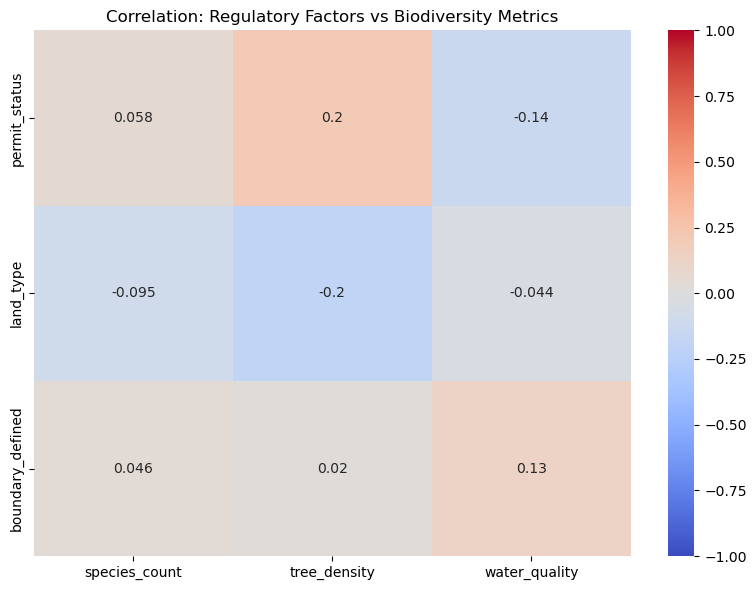

In [11]:
# 6. Buat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation: Regulatory Factors vs Biodiversity Metrics")
plt.tight_layout()
plt.savefig("filtered_mangrove_correlation_heatmap.png")

# Tampilkan langsung di output VS Code
plt.show()

In [4]:
print(df.columns.tolist())

['permit_status', 'land_type', 'boundary_defined', 'species_count', 'tree_density', 'rataan_kualitas_air']


In [2]:
import sys
!{sys.executable} -m pip install pandas seaborn matplotlib scikit-learn

  Using cached pandas-2.3.1-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp39-cp39-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp39-cp39-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached scip

ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "c:\Users\LENOVO\anaconda3\envs\studikasus1\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "c:\Users\LENOVO\anacond